In [28]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
import os
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.simplefilter('ignore')

In [2]:
# Read the dataset files list
file_list = pd.read_csv('./dataset/file_list.csv')
file_list.head()

,File,Category,Attack,Class
0,ARP_Spoofing_train.pcap.csv,SPOOFING,ARP Spoofing,1
1,Benign_train.pcap.csv,BENIGN,Benign,0
2,MQTT-DDoS-Connect_Flood_train.pcap.csv,MQTT,DDoS Connect Flood,1
3,MQTT-DDoS-Publish_Flood_train.pcap.csv,MQTT,DDoS Publish Flood,1
4,MQTT-DoS-Connect_Flood_train.pcap.csv,MQTT,DoS Connect Flood,1


In [4]:
# Load the dataset
data_dir = "./dataset/"
first_file_path = os.path.join(data_dir, file_list.iloc[0]['File'])
column_names = pd.read_csv(first_file_path, nrows=0).columns.tolist()

datasets_list = [] 

for _, row in file_list.iterrows():
    file_path = os.path.join(data_dir, row['File'])

    # Read files
    if os.path.exists(file_path):
        data = pd.read_csv(file_path, header=None, skiprows=1, names=column_names)

        # Add Category, Attack, and Class columns
        data['Category'] = row['Category']
        data['Attack'] = row['Attack']
        data['Class'] = row['Class']

        # Append the data to the datasets list
        datasets_list.append(data)
    else:
        print(f"File not found: {file_path}")

# Combine all datasets into a single DataFrame
dataset = pd.concat(datasets_list, ignore_index=True)
dataset

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Category,Attack,Class
0,866.600000,10.4,64.0,45722.390222,45722.390222,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,5.500000,16.963645,213.095221,66236.076476,0.900000,38.500000,SPOOFING,ARP Spoofing,1
1,3934.300000,12.6,131.2,35708.799475,35708.799475,0.0,0.0,0.0,0.0,0.3,...,1.694026e+08,13.500000,30.885371,708.919620,251721.126817,1.000000,244.600000,SPOOFING,ARP Spoofing,1
2,5592.800000,12.6,97.6,66.403506,66.403506,0.0,0.0,0.0,0.0,0.3,...,1.361110e-02,5.500000,21.787095,290.694475,84028.647525,0.900000,38.500000,SPOOFING,ARP Spoofing,1
3,9303.600000,14.8,80.8,51.201280,51.201280,0.0,0.0,0.0,0.0,0.1,...,1.694026e+08,13.500000,26.954506,597.046005,178453.001691,1.000000,244.600000,SPOOFING,ARP Spoofing,1
4,8592.400000,12.6,98.6,42.706455,42.706455,0.0,0.0,0.0,0.0,0.2,...,1.393099e-02,5.500000,24.255148,375.324132,80115.110731,0.900000,38.500000,SPOOFING,ARP Spoofing,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7160826,13234.910000,17.0,64.0,29460.045053,29460.045053,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.164175,8.453393,279.410488,0.130000,141.550000,DoS,DoS UDP,1
7160827,18136.530000,17.0,64.0,29318.535060,29318.535060,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.060924,3.012129,35.475423,0.130000,141.550000,DoS,DoS UDP,1
7160828,23038.040000,17.0,64.0,29363.556139,29363.556139,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,10.075262,3.287396,34.963050,0.160000,141.550000,DoS,DoS UDP,1
7160829,58526.160000,17.0,64.0,26168.955034,26168.955034,0.0,0.0,0.0,0.0,0.0,...,8.467524e+07,9.500000,18.631072,205.641671,70932.249555,0.350000,141.550000,DoS,DoS UDP,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160831 entries, 0 to 7160830
Data columns (total 48 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Header_Length    float64
 1   Protocol Type    float64
 2   Duration         float64
 3   Rate             float64
 4   Srate            float64
 5   Drate            float64
 6   fin_flag_number  float64
 7   syn_flag_number  float64
 8   rst_flag_number  float64
 9   psh_flag_number  float64
 10  ack_flag_number  float64
 11  ece_flag_number  float64
 12  cwr_flag_number  float64
 13  ack_count        float64
 14  syn_count        float64
 15  fin_count        float64
 16  rst_count        float64
 17  HTTP             float64
 18  HTTPS            float64
 19  DNS              float64
 20  Telnet           float64
 21  SMTP             float64
 22  SSH              float64
 23  IRC              float64
 24  TCP              float64
 25  UDP              float64
 26  DHCP             float64
 27  ARP         

In [6]:
dataset.describe()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,Class
count,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7160831.0,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,...,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06,7.160831e+06
mean,2.958836e+04,8.042957e+00,6.474653e+01,1.523202e+04,1.523202e+04,0.0,5.079549e-03,1.587609e-01,3.862139e-02,2.240655e-02,...,6.405743e+00,6.084036e+01,8.468349e+07,9.499081e+00,1.045008e+01,9.047367e+00,2.535226e+03,9.148464e-02,1.415273e+02,9.730852e-01
std,2.762618e+05,6.292201e+00,8.405262e+00,3.950968e+04,3.950968e+04,0.0,3.411170e-02,3.388233e-01,1.371016e-01,9.713147e-02,...,3.917360e+01,8.787628e+01,1.788442e+07,8.446717e-01,3.169197e+00,5.538149e+01,2.045832e+04,2.327133e-01,2.174138e+01,1.618343e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.200000e+01,-1.282061e+00,1.000000e+00,9.165151e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,5.400000e+01,1.160000e+00,6.400000e+01,6.685014e+00,6.685014e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,4.258000e+01,8.467888e+07,9.500000e+00,9.199377e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
50%,1.080000e+02,6.000000e+00,6.400000e+01,1.452887e+02,1.452887e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.000000e+01,8.469641e+07,9.500000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
75%,1.958050e+04,1.700000e+01,6.400000e+01,1.914681e+04,1.914681e+04,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,5.400000e+01,8.469686e+07,9.500000e+00,1.039230e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.415500e+02,1.000000e+00
max,9.895636e+06,1.700000e+01,2.550000e+02,2.097152e+06,2.097152e+06,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,7.211509e+02,1.514000e+03,1.694694e+08,1.500000e+01,5.502727e+01,1.020232e+03,5.204379e+05,1.000000e+00,2.446000e+02,1.000000e+00


In [17]:
def barplot_show(column, width=8):
    plt.figure(figsize=(width, 6))
    barplot = sb.barplot(y=dataset[column].value_counts().values, 
                      x=dataset[column].value_counts().index, 
                      palette="Spectral")
    barplot.set(xlabel=column, ylabel='Number of Samples')
    for p in barplot.patches:
        barplot.annotate(format(int(p.get_height()), 'd'), 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha = 'center', va = 'center', 
                         xytext = (0, 9), 
                         textcoords = 'offset points')
    plt.show()

In [12]:
dataset['Category'].value_counts()

Category
DDoS        4779859
DoS         1805529
MQTT         262938
BENIGN       192732
RECON        103726
SPOOFING      16047
Name: count, dtype: int64

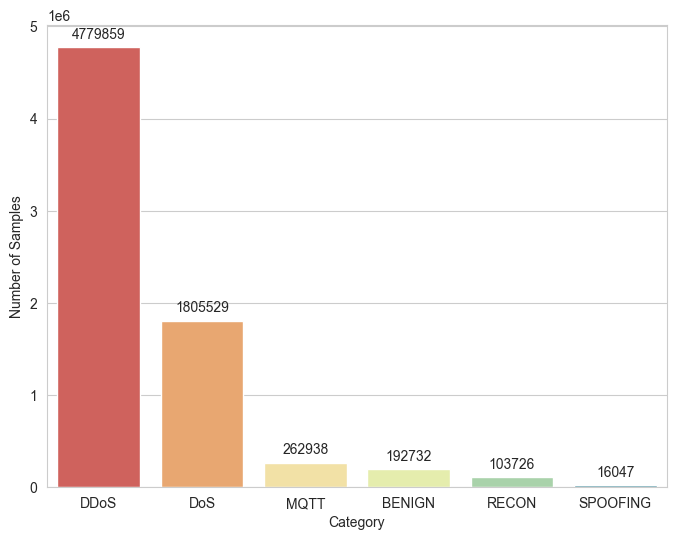

In [18]:
barplot_show('Category')

In [15]:
dataset['Attack'].value_counts()

Attack
DDoS UDP              1635956
DDoS ICMP             1537476
DDoS TCP               804465
DDoS SYN               801962
DoS UDP                566950
DoS SYN                441903
DoS ICMP               416292
DoS TCP                380384
Benign                 192732
DDoS Connect Flood     173036
Port Scan               83981
DoS Publish Flood       44376
DDoS Publish Flood      27623
OS Scan                 16832
ARP Spoofing            16047
DoS Connect Flood       12773
Malformed Data           5130
VulScan                  2173
Ping Sweep                740
Name: count, dtype: int64

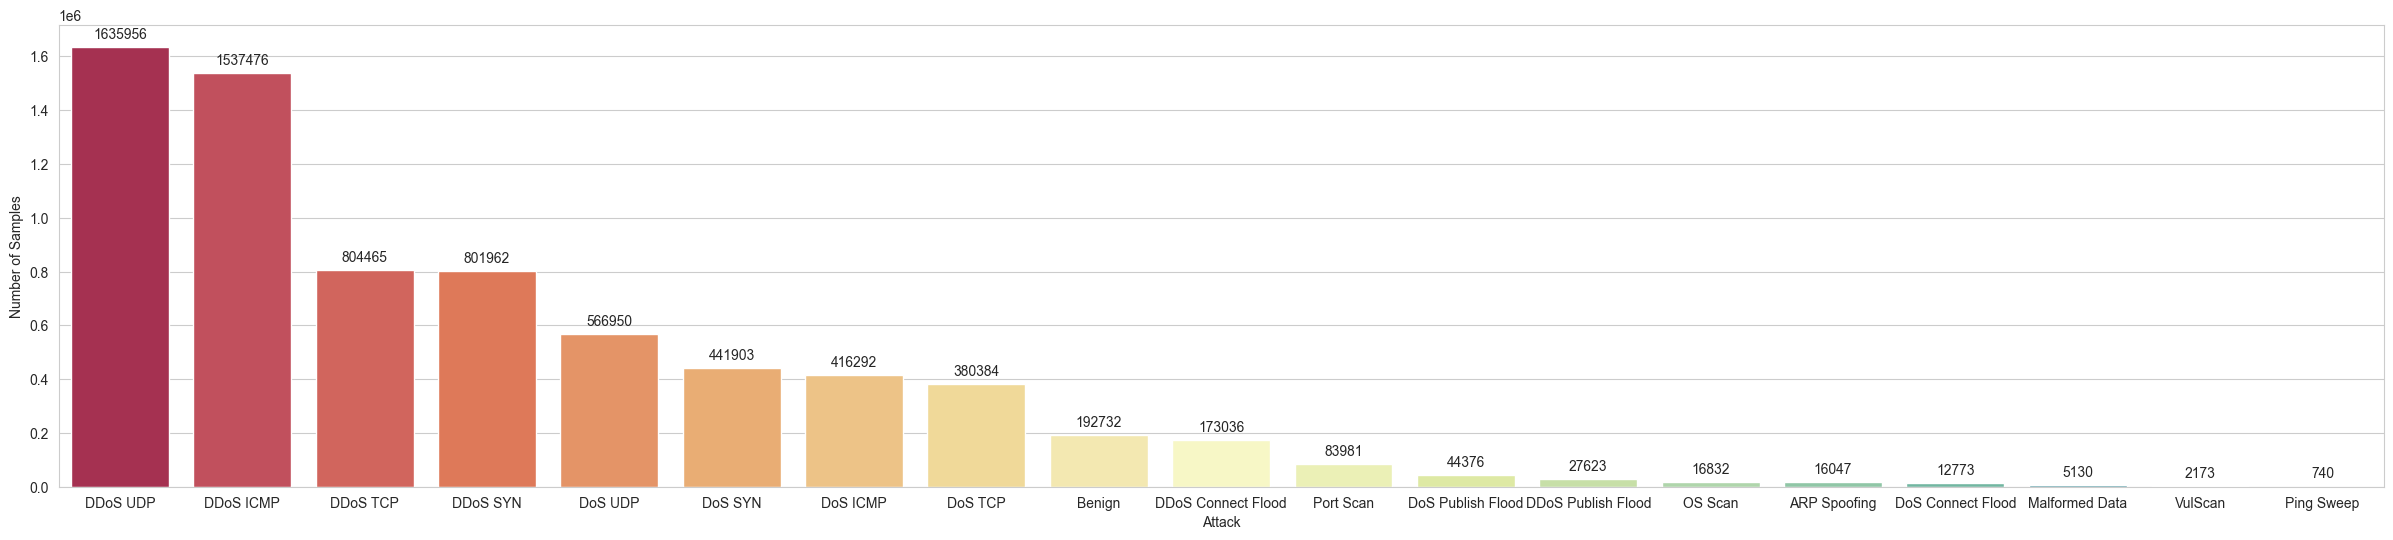

In [22]:
barplot_show('Attack', width=30)

In [23]:
dataset['Class'].value_counts()

Class
1    6968099
0     192732
Name: count, dtype: int64

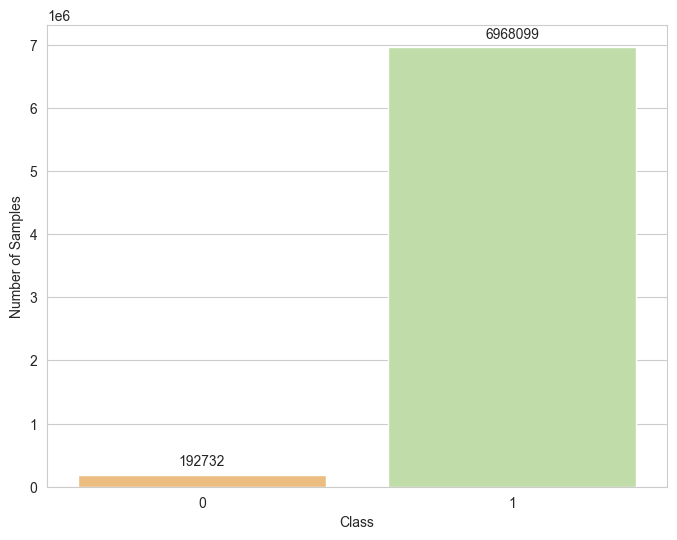

In [27]:
barplot_show('Class', width=8)

In [29]:
# scaled_data = MinMaxScaler().fit_transform(dataset)
# dataset = pd.DataFrame(scaled_data, columns=dataset.columns)
# dataset

ValueError: could not convert string to float: 'SPOOFING'

In [ ]:
# dataset.describe()